　ModelingToolkitやTuringなどのJuliaの道具がマーケティング的な発想と分析にどのように活用できるのかを試し、多くの人に利用してもらうことでユーザーの幅を広げることを目的としている。パッケージの詳細についてはそれぞれのマニュアルを参照されたい。ModelingToolkitは「微分方程式を記号的に扱う」パッケージで、TuringはMCMCという乱数発生アルゴリズムを利用し「パラメータを推定するパッケージ」という程度の理解でよい。

私の興味は産業の隆盛（ブーム）と衰退のメカニズムであり、ここでは具体例として「パチンコ」を取り上げる。1993年以降のパチンコユーザー調査を利用する。データは日本生産性本部の「レジャー白書」を参照している。

In [1]:
using CSV,StatsPlots,DataFrames

In [2]:
df = CSV.read("pdata.csv", DataFrame)

Row,Year,P_USER,V_PEOPLE
,Int64,Int64,Int64
1,1994,29300,125265
2,1995,29000,125570
3,1996,27600,125859
4,1997,23100,126157
5,1998,19800,126472
6,1999,18600,126667
7,2000,20200,126926
8,2001,19300,126926
9,2002,21700,127316


1994年のプレイヤー人口2930万から持続的に減少し2016年以降は1000万以下が常態となっている。プレイヤーの減少はどこまで続くのだろうか？

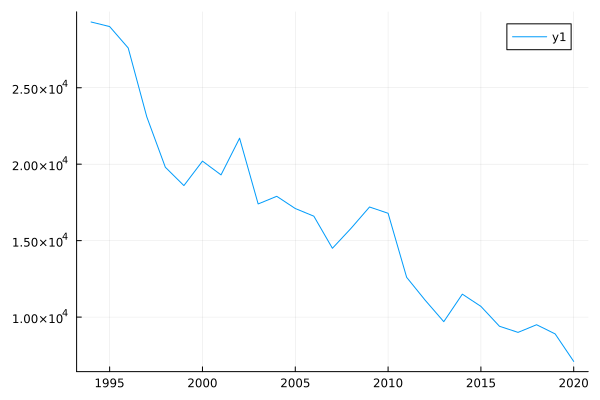

In [3]:
@df df plot(:Year,:P_USER)

In [4]:
using Catalyst,DifferentialEquations,StatsPlots
using ModelingToolkit

人類はパチンコプレイヤーとパチンコをやらない人（「ノンプレイヤー」）に二分される。ここでいう「パチンコプレイヤー」は年間で1回以上ホールで遊戯を行った人と定義される。プレイヤーのほとんどは20代のはじめに（多くは先輩や上司に連れられて）エントリーし、結婚や引っ越し、転職、金融状況、病気、価値観の変化などで遊戯を中断したり再開したりをする。何がプレイを再開させているのかはよくわかっていない。好きなコンテンツやキャラクターがそうさせる場合もあるし、たまたま近所にホールがあったとか、人間関係の変化かもしれない。しかしいずれにしてもそのような理由はプレイヤー・ノンプレイヤー全体に対して一定の確率で発生すると思われる。

プレイヤーはある一定の確率でノンプレイヤーになるし、ノンプレイヤーも一定の確率でプレイヤーになる。この関係を微分方程式に簡単に変換できるツールが　Catalyst.jl　である。はっきり言ってここでは紹介のために使ってみただけだ。

In [5]:
rn = @reaction_network begin
    e, N --> P
    r, P --> N
end

Model ##ReactionSystem#302
States (2):
  N(t)
  P(t)
Parameters (2):
  e
  r

ConvertでODESystemに変換できる。ここで微分方程式のデザインが確認できる

In [6]:
convert(ODESystem, rn)

Model ##ReactionSystem#302 with 2 equations
States (2):
  N(t)
  P(t)
Parameters (2):
  e
  r

パラメータの略語をこのように整理しよう。
### Parameters
 - e =>パチンコ遊戯へのエントリー(entry)の係数
 - r =>パチンコ遊戯を中断(retire)係数
 - b =>人口変動。死亡や誕生（birth）による人口全体の変動係数
 
### Variables
 - N => Non-Player パチンコノンユーザー
 - P => Pachinko Playerパチンコユーザー
 - V => 人口全体（N＋P）

パチンコユーザー<=>ノンユーザーモデルの状態変数とパラメーターを設定する。teventはパラメータや状態に大きな変化を与えるイベント（カタストロフィーイベント catastrophe events）を記述するためだ。

In [7]:
@variables t P(t) V(t) N(t)
@parameters  r e b tevent
D = Differential(t)

(::Differential) (generic function with 3 methods)

微分方程式のモデルを書く。人口の変動分dV(t)は死亡／誕生による差分なので、いずれもノンユーザーとしてモデルに組み込む。

In [8]:
eqs = [ D(P) ~ e * ( V - P )  - r * P
        D(N) ~ r * P  - e *( V - P) + D(V)
        D(V) ~ b
        ]

3-element Vector{Equation}:
 Differential(t)(P(t)) ~ e*(V(t) - P(t)) - r*P(t)
 Differential(t)(N(t)) ~ Differential(t)(V(t)) - e*(V(t) - P(t)) + r*P(t)
 Differential(t)(V(t)) ~ b

## 適当な数字でパラメータを指定してみる

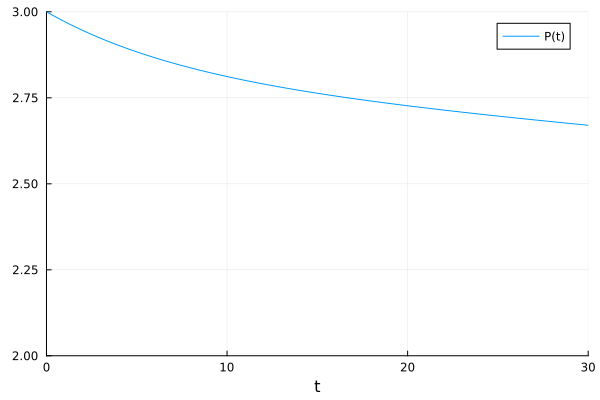

In [15]:
u0 = [P => 3.0 ,N => 9.0, V => 12.0]
ps = [b => -0.02, e => 0.03, r => 0.1]
tspan=(0,30.0)
@named sys = ODESystem(eqs, t)
sys = structural_simplify(sys)

prob = ODEProblem(sys, u0, tspan, ps)
sol = solve(prob)
plot(sol,idxs=[P],ylims=(2,3))

### t=10 と t＝16 で１割のプレイヤーが離脱するカタストロフィーを組み込んだ。

In [10]:
u0 = [P => 3.0 ,N => 9.0, V => 12.0]
ps = [b => -0.02, e => 0.03, r => 0.1]
tspan=(0,30.0)

#discrete_events  = [ (t > 10.0 ) =>  [ e ~ 0, r ~ 0] , (t > 16.0 ) =>  [ e ~ 0.03, r ~ 0.06] ]
event_10 = (t == 10 ) => [ P ~ P * 0.9 ] 
event_16 = (t == 16 ) => [ P ~ P * 0.9 ] 
@named sys_cata = ODESystem(eqs, t, [P,N,V], [b,e,r] ; discrete_events = [event_10, event_16])
sys_cata = structural_simplify(sys_cata) ;

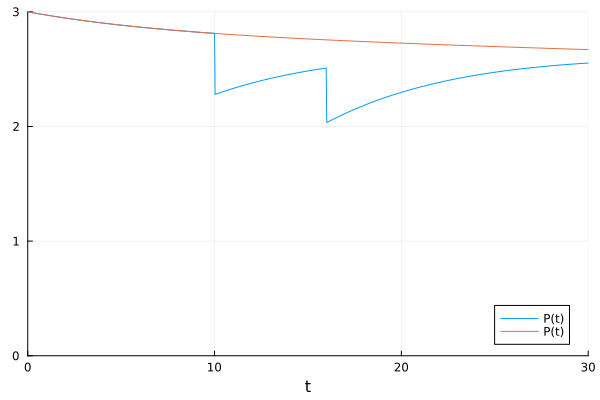

In [12]:
prob_cata = ODEProblem(sys_cata, u0, tspan, ps)
sol2 = solve(prob_cata ;tstops = [10.0, 16.0])
plot(sol2,idxs=[P])
plot!(sol,idxs=[P],ylims=(0,3))

### パラメータが変化しない限り収束点へ回復する

In [16]:
using DataFrames, CSV

## 観測値をもとにモデルのパラメータを発見する

In [19]:
dx = CSV.read(joinpath("p-datasets2.csv"),DataFrame)
for (i,e) in enumerate(names(dx))
    print("$i : $e ,")
end
eq = zeros(31) ; eq[23:end] .= 1.0
dx.eq = eq ;
#dx.パチンコ参加人口 = dx.パチンコ参加人口 .* 10 ;
dx

1 : 年 ,2 : 労働時間 ,3 : 名目賃金 ,4 : 実質賃金 ,5 : 店舗あたり平均台数 ,6 : 証紙発行数 ,7 : 総人口 ,8 : 男女20代 ,9 : 男女30代 ,10 : 男女40代 ,11 : 男女50代 ,12 : 男女60代以上 ,13 : 東京GRP ,14 : 大阪GRP ,15 : 名古屋GRP ,16 : 店舗数 ,17 : パチンコ参加人口 ,

Row,年,労働時間,名目賃金,実質賃金,店舗あたり平均台数,証紙発行数,総人口,男女20代,男女30代,男女40代,男女50代,男女60代以上,東京GRP,大阪GRP,名古屋GRP,店舗数,パチンコ参加人口,eq
,Int64,Float64?,Float64?,Float64?,Float64,Int64?,Int64,Int64,Int64?,Int64?,Int64?,Int64?,Float64?,Float64?,Float64?,Int64,Int64?,Float64
1,1989,missing,missing,missing,193.8,missing,123205,16756,missing,missing,missing,missing,missing,missing,missing,16068,missing,0.0
2,1990,127.1,100.3,111.8,201.1,missing,123611,16923,missing,missing,missing,missing,missing,missing,missing,16074,missing,0.0
3,1991,124.3,104.8,113.1,194.6,missing,124101,17375,missing,missing,missing,missing,missing,missing,missing,17373,missing,0.0
4,1992,121.5,106.9,113.5,189.8,missing,124567,17849,missing,missing,missing,missing,missing,missing,missing,17827,missing,0.0
5,1993,118.2,107.1,112.4,198.0,missing,124938,18301,missing,missing,missing,missing,missing,missing,missing,18036,missing,0.0
6,1994,117.7,108.7,113.6,205.5,missing,125265,18658,missing,missing,missing,missing,missing,missing,missing,18113,29300,0.0
7,1995,117.8,109.9,115.1,209.8,missing,125570,18706,missing,missing,missing,missing,missing,missing,missing,18244,29000,0.0
8,1996,117.9,111.1,116.5,215.1,missing,125859,19130,missing,missing,missing,missing,missing,missing,missing,18164,27600,0.0
9,1997,116.3,112.9,116.4,216.8,missing,126157,19082,missing,missing,missing,missing,missing,missing,missing,17773,23100,0.0


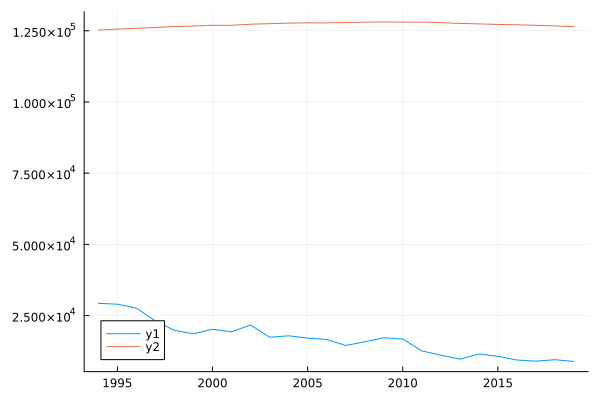

In [20]:
Pu = dx.パチンコ参加人口[6:end]
Vu = dx.総人口[6:end]
year = dx.年[6:end]
plot(year,[Pu,Vu])

In [21]:
function serial(t; data=data)
    #@assert t < length(data) - 1
    if t < 1
        ff = data[1]
        nn = (data[2] - data[1]) * t
    else
        f = floor(t)
        n = t - f
        ff = data[ f+1 |> Int]
        ffn = f+2 > length(data) ? data[end] : data[(f+2) |> Int]
        if n != 0
            nn =  (ffn - ff ) * n 
        else
            nn = 0
        end
    end

    return ff+nn
end

serial (generic function with 1 method)

In [22]:
pu_func(t) = serial(t ; data=Pu)
vu_func(t) = serial(t ; data=Vu)

vu_func (generic function with 1 method)

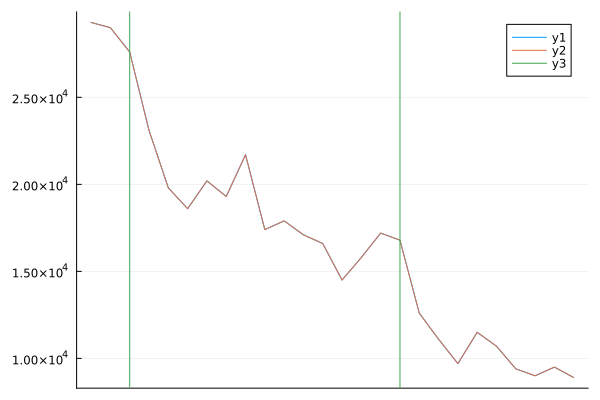

In [23]:
xs = 0:0.1:length(Pu)-1
plot(xs,[pu_func(x) for x =xs],xticks=year)
plot!(0:length(Pu)-1,Pu)
vline!([2,16])

year

In [24]:
using Zygote

In [25]:
dvu(τ) = begin
    rs = gradient(x->vu_func(x), τ)[1]
    if rs == nothing 
        (dvu(τ + 0.1) + dvu( τ - 0.1))/2
    else
        rs
    end
end

dvu (generic function with 1 method)

In [26]:
dvu(16) 

-13.5

In [27]:
d_vu =[dvu(t) for t in xs] ;

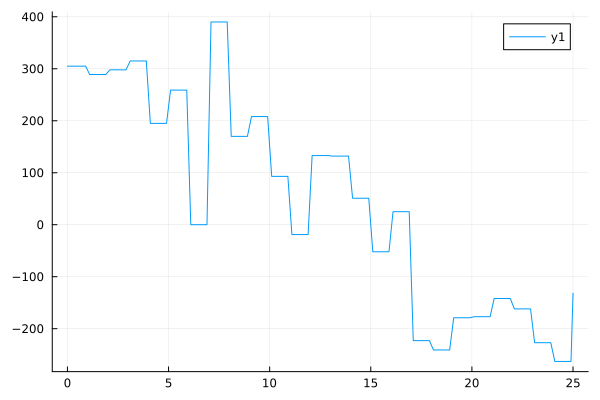

In [28]:
plot(xs, d_vu)


In [29]:
@variables t P(t) V(t) N(t)
@parameters  r e b 
D = Differential(t)

(::Differential) (generic function with 3 methods)

In [30]:
@register_symbolic pu_func(t)
@register_symbolic vu_func(t)
@register_symbolic dvu(t)

## このモデルが正しい

In [31]:
eqs = [ D(P) ~ e * ( V - P )  - r * P
        D(N) ~ r * P  - e *( V - P) + D(V)
        D(V) ~ b
        ]

3-element Vector{Equation}:
 Differential(t)(P(t)) ~ e*(V(t) - P(t)) - r*P(t)
 Differential(t)(N(t)) ~ Differential(t)(V(t)) - e*(V(t) - P(t)) + r*P(t)
 Differential(t)(V(t)) ~ b

In [32]:
u0 = [P => 7.0 ,N => 10.0, V => 10.0]
ps = [b => -0.02, e => 0.25, r=> 0.2]
tspan=(0,30.0)
@named sys = ODESystem(eqs, t)
sys = structural_simplify(sys)

Model sys with 3 equations
States (3):
  P(t)
  V(t)
  N(t)
Parameters (3):
  r
  e
  b
Incidence matrix:3×6 SparseArrays.SparseMatrixCSC{Num, Int64} with 7 stored entries:
 ×  ×  ⋅  ×  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ×  ⋅
 ×  ×  ⋅  ⋅  ⋅  ×

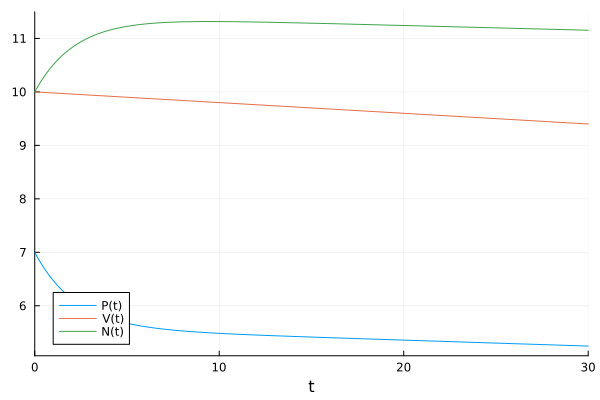

In [33]:
prob_vs = ODEProblem(sys, u0, tspan, ps)
sol = solve(prob_vs)
plot(sol)

In [34]:
eqs_v = [  D(P) ~ e * ( V - P )  - r * P
           D(N) ~ r * P  - e *( V - P) + D(V)
           D(V) ~ dvu(t)
        ]

3-element Vector{Equation}:
 Differential(t)(P(t)) ~ e*(V(t) - P(t)) - r*P(t)
 Differential(t)(N(t)) ~ Differential(t)(V(t)) - e*(V(t) - P(t)) + r*P(t)
 Differential(t)(V(t)) ~ dvu(t)

In [35]:
@named sysv = ODESystem(eqs_v, t)
sysv = structural_simplify(sysv)

Model sysv with 3 equations
States (3):
  P(t)
  V(t)
  N(t)
Parameters (2):
  r
  e
Incidence matrix:3×6 SparseArrays.SparseMatrixCSC{Num, Int64} with 7 stored entries:
 ×  ×  ⋅  ×  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ×  ⋅
 ×  ×  ⋅  ⋅  ⋅  ×

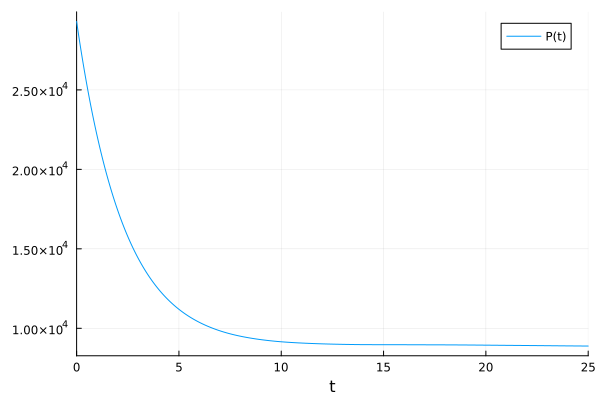

In [36]:
u0 = [P => Pu[1] ,N => Vu[1] - Pu[1] , V => Vu[1]]
ps = [e => 0.03, r=> 0.4]
tspan=(0,length(year)-1)
probv = ODEProblem(sysv, u0, tspan, ps)
solv = solve(probv)
plot(solv, idxs=[P])

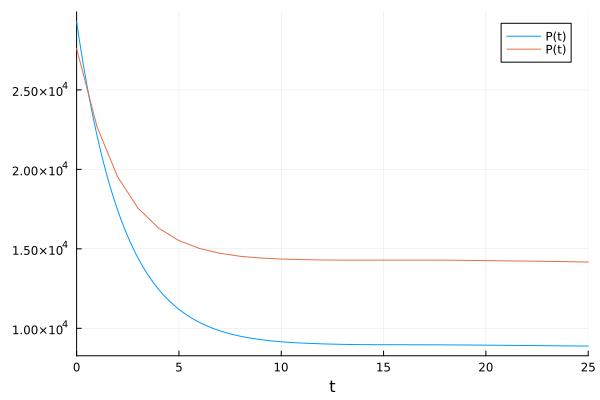

In [37]:
rprob=remake(probv ; u0 = [P => Pu[3] ,N => Vu[3] - Pu[3] , V => Vu[3]], p=[e=> 0.05, r=>0.4]) 
rsolv=solve(rprob, saveat=collect(0:25))
plot!(rsolv, idxs=[P])

In [38]:
rsolv.u[2][1]

22672.648922722557

In [39]:
using Turing, Distributions

In [40]:
@model function findprm(prob, Px, Vx, ts) # findprm(Pu, Vu, probv)
    n = length(Px)
    entry  ~ truncated(TDist(3), 1e-3, 1 - 1e-3)
    retire ~ truncated(TDist(3), 1e-3, 1 - 1e-3 )
    s ~ InverseGamma(2,3)
    
    prob = remake(prob ; 
            u0= [ P => Px[1], N => Vx[1] - Px[1], V => Vx[1] ],
            p = [ e => entry, r => retire],
            tspan = ts
    )
    solv = solve(prob, saveat=collect(ts[1]:ts[end]) )
    
    for i = 1:n
        Px[i] ~ Normal(solv.u[i][1], s) 
    end
    return (; Ps = [])
end
    

findprm (generic function with 2 methods)

In [41]:
ts =  (0.0, 25.0 )
model = findprm(probv, Pu, Vu, ts)
chain = sample(model, NUTS(.64), 2000, progress=false)

Sampling   0%|█                                         |  ETA: N/A


┌ Info: Found initial step size
│   ϵ = 2.44140625e-5
└ @ Turing.Inference C:\Users\kimse\.julia\packages\Turing\UCuzt\src\mcmc\hmc.jl:192


Sampling   0%|█                                         |  ETA: 2:03:39


Sampling   1%|█                                         |  ETA: 1:04:28


Sampling   2%|█                                         |  ETA: 0:44:56


Sampling   2%|█                                         |  ETA: 0:35:41


Sampling   2%|██                                        |  ETA: 0:30:42


Sampling   3%|██                                        |  ETA: 0:28:33


Sampling   4%|██                                        |  ETA: 0:26:06


Sampling   4%|██                                        |  ETA: 0:24:25


Sampling   4%|██                                        |  ETA: 0:22:56


Sampling   5%|███                                       |  ETA: 0:23:21


Sampling   6%|███                                       |  ETA: 0:21:30


Sampling   6%|███                                       |  ETA: 0:20:06


Sampling   6%|███                                       |  ETA: 0:18:46


Sampling   7%|███                                       |  ETA: 0:17:41


Sampling   8%|████                                      |  ETA: 0:16:48


Sampling   8%|████                                      |  ETA: 0:15:53


Sampling   8%|████                                      |  ETA: 0:15:03


Sampling   9%|████                                      |  ETA: 0:14:22


Sampling  10%|████                                      |  ETA: 0:14:01


Sampling  10%|█████                                     |  ETA: 0:13:36


Sampling  10%|█████                                     |  ETA: 0:13:05


Sampling  11%|█████                                     |  ETA: 0:12:32


Sampling  12%|█████                                     |  ETA: 0:12:10


Sampling  12%|██████                                    |  ETA: 0:11:45


Sampling  12%|██████                                    |  ETA: 0:11:19


Sampling  13%|██████                                    |  ETA: 0:11:00


Sampling  14%|██████                                    |  ETA: 0:10:47


Sampling  14%|██████                                    |  ETA: 0:10:34


Sampling  14%|███████                                   |  ETA: 0:10:19


Sampling  15%|███████                                   |  ETA: 0:10:08


Sampling  16%|███████                                   |  ETA: 0:10:02


Sampling  16%|███████                                   |  ETA: 0:09:46


Sampling  16%|███████                                   |  ETA: 0:09:43


Sampling  17%|████████                                  |  ETA: 0:09:28


Sampling  18%|████████                                  |  ETA: 0:09:14


Sampling  18%|████████                                  |  ETA: 0:09:05


Sampling  18%|████████                                  |  ETA: 0:08:55


Sampling  19%|████████                                  |  ETA: 0:08:44


Sampling  20%|█████████                                 |  ETA: 0:08:42


Sampling  20%|█████████                                 |  ETA: 0:08:33


Sampling  20%|█████████                                 |  ETA: 0:08:27


Sampling  21%|█████████                                 |  ETA: 0:08:19


Sampling  22%|██████████                                |  ETA: 0:08:07


Sampling  22%|██████████                                |  ETA: 0:07:59


Sampling  22%|██████████                                |  ETA: 0:07:49


Sampling  23%|██████████                                |  ETA: 0:07:43


Sampling  24%|██████████                                |  ETA: 0:07:37


Sampling  24%|███████████                               |  ETA: 0:07:29


Sampling  24%|███████████                               |  ETA: 0:07:23


Sampling  25%|███████████                               |  ETA: 0:07:15


Sampling  26%|███████████                               |  ETA: 0:07:07


Sampling  26%|███████████                               |  ETA: 0:07:01


Sampling  26%|████████████                              |  ETA: 0:06:55


Sampling  27%|████████████                              |  ETA: 0:06:48


Sampling  28%|████████████                              |  ETA: 0:06:43


Sampling  28%|████████████                              |  ETA: 0:06:38


Sampling  28%|████████████                              |  ETA: 0:06:34


Sampling  29%|█████████████                             |  ETA: 0:06:27


Sampling  30%|█████████████                             |  ETA: 0:06:22


Sampling  30%|█████████████                             |  ETA: 0:06:19


Sampling  30%|█████████████                             |  ETA: 0:06:14


Sampling  31%|██████████████                            |  ETA: 0:06:08


Sampling  32%|██████████████                            |  ETA: 0:06:03


Sampling  32%|██████████████                            |  ETA: 0:05:58


Sampling  32%|██████████████                            |  ETA: 0:06:00


Sampling  33%|██████████████                            |  ETA: 0:05:58


Sampling  34%|███████████████                           |  ETA: 0:05:54


Sampling  34%|███████████████                           |  ETA: 0:05:49


Sampling  34%|███████████████                           |  ETA: 0:05:45


Sampling  35%|███████████████                           |  ETA: 0:05:41


Sampling  36%|███████████████                           |  ETA: 0:05:37


Sampling  36%|████████████████                          |  ETA: 0:05:34


Sampling  36%|████████████████                          |  ETA: 0:05:31


Sampling  37%|████████████████                          |  ETA: 0:05:27


Sampling  38%|████████████████                          |  ETA: 0:05:23


Sampling  38%|████████████████                          |  ETA: 0:05:19


Sampling  38%|█████████████████                         |  ETA: 0:05:15


Sampling  39%|█████████████████                         |  ETA: 0:05:13


Sampling  40%|█████████████████                         |  ETA: 0:05:09


Sampling  40%|█████████████████                         |  ETA: 0:05:06


Sampling  40%|██████████████████                        |  ETA: 0:05:02


Sampling  41%|██████████████████                        |  ETA: 0:04:59


Sampling  42%|██████████████████                        |  ETA: 0:04:56


Sampling  42%|██████████████████                        |  ETA: 0:04:52


Sampling  42%|██████████████████                        |  ETA: 0:04:49


Sampling  43%|███████████████████                       |  ETA: 0:04:46


Sampling  44%|███████████████████                       |  ETA: 0:04:43


Sampling  44%|███████████████████                       |  ETA: 0:04:40


Sampling  44%|███████████████████                       |  ETA: 0:04:36


Sampling  45%|███████████████████                       |  ETA: 0:04:33


Sampling  46%|████████████████████                      |  ETA: 0:04:29


Sampling  46%|████████████████████                      |  ETA: 0:04:25


Sampling  46%|████████████████████                      |  ETA: 0:04:21


Sampling  47%|████████████████████                      |  ETA: 0:04:18


Sampling  48%|████████████████████                      |  ETA: 0:04:15


Sampling  48%|█████████████████████                     |  ETA: 0:04:12


Sampling  48%|█████████████████████                     |  ETA: 0:04:09


Sampling  49%|█████████████████████                     |  ETA: 0:04:06


Sampling  50%|█████████████████████                     |  ETA: 0:04:04


Sampling  50%|██████████████████████                    |  ETA: 0:04:01


Sampling  50%|██████████████████████                    |  ETA: 0:03:58


Sampling  51%|██████████████████████                    |  ETA: 0:03:56


Sampling  52%|██████████████████████                    |  ETA: 0:03:53


Sampling  52%|██████████████████████                    |  ETA: 0:03:50


Sampling  52%|███████████████████████                   |  ETA: 0:03:48


Sampling  53%|███████████████████████                   |  ETA: 0:03:45


Sampling  54%|███████████████████████                   |  ETA: 0:03:42


Sampling  54%|███████████████████████                   |  ETA: 0:03:39


Sampling  55%|███████████████████████                   |  ETA: 0:03:37


Sampling  55%|████████████████████████                  |  ETA: 0:03:34


Sampling  56%|████████████████████████                  |  ETA: 0:03:32


Sampling  56%|████████████████████████                  |  ETA: 0:03:29


Sampling  56%|████████████████████████                  |  ETA: 0:03:26


Sampling  57%|████████████████████████                  |  ETA: 0:03:24


Sampling  57%|█████████████████████████                 |  ETA: 0:03:21


Sampling  58%|█████████████████████████                 |  ETA: 0:03:18


Sampling  58%|█████████████████████████                 |  ETA: 0:03:16


Sampling  59%|█████████████████████████                 |  ETA: 0:03:13


Sampling  60%|█████████████████████████                 |  ETA: 0:03:10


Sampling  60%|██████████████████████████                |  ETA: 0:03:08


Sampling  60%|██████████████████████████                |  ETA: 0:03:05


Sampling  61%|██████████████████████████                |  ETA: 0:03:02


Sampling  62%|██████████████████████████                |  ETA: 0:03:00


Sampling  62%|███████████████████████████               |  ETA: 0:02:57


Sampling  62%|███████████████████████████               |  ETA: 0:02:54


Sampling  63%|███████████████████████████               |  ETA: 0:02:52


Sampling  64%|███████████████████████████               |  ETA: 0:02:49


Sampling  64%|███████████████████████████               |  ETA: 0:02:47


Sampling  64%|████████████████████████████              |  ETA: 0:02:44


Sampling  65%|████████████████████████████              |  ETA: 0:02:42


Sampling  66%|████████████████████████████              |  ETA: 0:02:39


Sampling  66%|████████████████████████████              |  ETA: 0:02:37


Sampling  66%|████████████████████████████              |  ETA: 0:02:34


Sampling  67%|█████████████████████████████             |  ETA: 0:02:31


Sampling  68%|█████████████████████████████             |  ETA: 0:02:29


Sampling  68%|█████████████████████████████             |  ETA: 0:02:27


Sampling  68%|█████████████████████████████             |  ETA: 0:02:24


Sampling  69%|█████████████████████████████             |  ETA: 0:02:22


Sampling  70%|██████████████████████████████            |  ETA: 0:02:20


Sampling  70%|██████████████████████████████            |  ETA: 0:02:17


Sampling  70%|██████████████████████████████            |  ETA: 0:02:14


Sampling  71%|██████████████████████████████            |  ETA: 0:02:12


Sampling  72%|███████████████████████████████           |  ETA: 0:02:10


Sampling  72%|███████████████████████████████           |  ETA: 0:02:07


Sampling  72%|███████████████████████████████           |  ETA: 0:02:05


Sampling  73%|███████████████████████████████           |  ETA: 0:02:02


Sampling  74%|███████████████████████████████           |  ETA: 0:02:00


Sampling  74%|████████████████████████████████          |  ETA: 0:01:58


Sampling  74%|████████████████████████████████          |  ETA: 0:01:55


Sampling  75%|████████████████████████████████          |  ETA: 0:01:53


Sampling  76%|████████████████████████████████          |  ETA: 0:01:50


Sampling  76%|████████████████████████████████          |  ETA: 0:01:48


Sampling  76%|█████████████████████████████████         |  ETA: 0:01:46


Sampling  77%|█████████████████████████████████         |  ETA: 0:01:43


Sampling  78%|█████████████████████████████████         |  ETA: 0:01:41


Sampling  78%|█████████████████████████████████         |  ETA: 0:01:39


Sampling  78%|█████████████████████████████████         |  ETA: 0:01:36


Sampling  79%|██████████████████████████████████        |  ETA: 0:01:34


Sampling  80%|██████████████████████████████████        |  ETA: 0:01:32


Sampling  80%|██████████████████████████████████        |  ETA: 0:01:29


Sampling  80%|██████████████████████████████████        |  ETA: 0:01:27


Sampling  81%|███████████████████████████████████       |  ETA: 0:01:25


Sampling  82%|███████████████████████████████████       |  ETA: 0:01:22


Sampling  82%|███████████████████████████████████       |  ETA: 0:01:20


Sampling  82%|███████████████████████████████████       |  ETA: 0:01:18


Sampling  83%|███████████████████████████████████       |  ETA: 0:01:16


Sampling  84%|████████████████████████████████████      |  ETA: 0:01:13


Sampling  84%|████████████████████████████████████      |  ETA: 0:01:11


Sampling  84%|████████████████████████████████████      |  ETA: 0:01:09


Sampling  85%|████████████████████████████████████      |  ETA: 0:01:06


Sampling  86%|████████████████████████████████████      |  ETA: 0:01:04


Sampling  86%|█████████████████████████████████████     |  ETA: 0:01:02


Sampling  86%|█████████████████████████████████████     |  ETA: 0:01:00


Sampling  87%|█████████████████████████████████████     |  ETA: 0:00:58


Sampling  88%|█████████████████████████████████████     |  ETA: 0:00:55


Sampling  88%|█████████████████████████████████████     |  ETA: 0:00:53


Sampling  88%|██████████████████████████████████████    |  ETA: 0:00:51
Sampling  89%|██████████████████████████████████████    |  ETA: 0:00:49


Sampling  90%|██████████████████████████████████████    |  ETA: 0:00:46


Sampling  90%|██████████████████████████████████████    |  ETA: 0:00:44


Sampling  90%|███████████████████████████████████████   |  ETA: 0:00:42


Sampling  91%|███████████████████████████████████████   |  ETA: 0:00:40


Sampling  92%|███████████████████████████████████████   |  ETA: 0:00:37
Sampling  92%|███████████████████████████████████████   |  ETA: 0:00:35


Sampling  92%|███████████████████████████████████████   |  ETA: 0:00:33


Sampling  93%|████████████████████████████████████████  |  ETA: 0:00:31


Sampling  94%|████████████████████████████████████████  |  ETA: 0:00:29


Sampling  94%|████████████████████████████████████████  |  ETA: 0:00:26


Sampling  94%|████████████████████████████████████████  |  ETA: 0:00:24


Sampling  95%|████████████████████████████████████████  |  ETA: 0:00:22


Sampling  96%|█████████████████████████████████████████ |  ETA: 0:00:20


Sampling  96%|█████████████████████████████████████████ |  ETA: 0:00:18


Sampling  96%|█████████████████████████████████████████ |  ETA: 0:00:15
Sampling  97%|█████████████████████████████████████████ |  ETA: 0:00:13


Sampling  98%|█████████████████████████████████████████ |  ETA: 0:00:11


Sampling  98%|██████████████████████████████████████████|  ETA: 0:00:09


Sampling  98%|██████████████████████████████████████████|  ETA: 0:00:07


Sampling  99%|██████████████████████████████████████████|  ETA: 0:00:04


Sampling 100%|██████████████████████████████████████████|  ETA: 0:00:02


Sampling 100%|██████████████████████████████████████████| Time: 0:07:11


Sampling 100%|██████████████████████████████████████████| Time: 0:07:11


Chains MCMC chain (2000×15×1 Array{Float64, 3}):

Iterations        = 1001:1:3000
Number of chains  = 1
Samples per chain = 2000
Wall duration     = 433.47 seconds
Compute duration  = 433.47 seconds
parameters        = entry, retire, s
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters        mean        std      mcse   ess_bulk   ess_tail      rhat  ⋯
      Symbol     Float64    Float64   Float64    Float64    Float64   Float64  ⋯

       entry      0.0034     0.0014    0.0001   196.4214   386.9101    1.0100  ⋯
      retire      0.0695     0.0085    0.0006   189.6112   298.2213    1.0120  ⋯
           s   1762.9736   261.6314   18.0983   176.8084   216.9578    1.0011  ⋯
                                                                1 column omitted

Quantiles
  parameters        2.5%       25.0%      

In [42]:
rs = get(chain, [:entry, :retire])
ts_0 = (; e = rs[:entry]  |> mean, r = rs[:retire] |> mean)

(e = 0.003359224664706175, r = 0.06945164983656889)

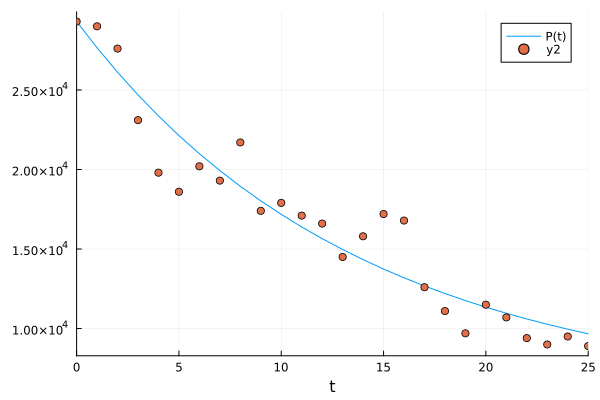

In [43]:
rsol =solve( remake( probv, p = [e => ts_0.e, r => ts_0.r]) , saveat=collect(ts[1]:ts[end]))
plot(rsol, idxs=[P])
scatter!(0:ts[2], Pu)

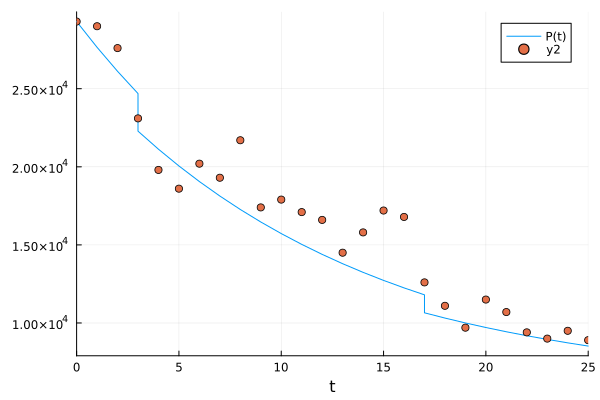

In [44]:
u0 = [P => Pu[1] ,N => Vu[1] - Pu[1] , V => Vu[1]]
ps = [e => ts_0.e, r => ts_0.r ]
tspan=(0,length(year)-1)
event_10 = ( t == 3 ) => [ P ~ P * 0.95 ] 
event_16 = ( t == 17 ) => [ P ~ P * 0.95 ] 
@named sys_cata = ODESystem(eqs_v, t, [P,N,V], [e,r] ; discrete_events = [event_10, event_16])
sys_cata = structural_simplify(sys_cata) 
prob_cata = ODEProblem(sys_cata, u0, tspan, ps)
sol = solve(prob_cata, saveat=collect(ts[1]:ts[end]), tstops = [3, 17.0])
plot(sol, idxs=[P] )
scatter!(0:ts[2], Pu)

In [45]:
@model function findprmevent(prob, Px, Vx, ts ) # findprm(Pu, Vu, probv)
    n = length(Px)
    entry  ~ truncated(TDist(3), 1e-4, 1 - 1e-4)
    retire ~ truncated(TDist(3), 1e-4, 1 - 1e-4 )
    s ~ InverseGamma(2,3)
    
    prob = remake( prob ; 
            u0= [ P => Px[1], N => Vx[1] - Px[1], V => Vx[1] ],
            p = [ e => entry, r => retire],
            tspan = ts
    )
    solv = solve(prob ; saveat=collect(ts[1]:ts[end]) , tstops = [3.0, 17.0] )
    # t が繰り返される
    countlist=collect(1:26) |> t-> [e > 3 ? e + 3 : e for e in t] |> t->[e > 17 ? e + 3 : e for e in t]
    countlist[4] -= 1
    countlist[17] -= 1
    
    for (i,e) in enumerate(countlist)
        Px[i] ~ Normal(solv.u[e][1], s) 
    end
    return (; Ps = [])
end
    

    

findprmevent (generic function with 2 methods)

In [46]:
ts =  (0.0, 25.0 )
model = findprmevent(prob_cata, Pu, Vu, ts)
chain = sample(model, NUTS(.64), 2000, progress=false)

Sampling   0%|█                                         |  ETA: N/A


┌ Info: Found initial step size
│   ϵ = 3.0517578125e-6
└ @ Turing.Inference C:\Users\kimse\.julia\packages\Turing\UCuzt\src\mcmc\hmc.jl:192


Sampling   0%|█                                         |  ETA: 1:04:44


Sampling   1%|█                                         |  ETA: 0:37:00


Sampling   2%|█                                         |  ETA: 0:32:38


Sampling   2%|█                                         |  ETA: 0:28:12


Sampling   2%|██                                        |  ETA: 0:24:38


Sampling   3%|██                                        |  ETA: 0:21:30


Sampling   4%|██                                        |  ETA: 0:19:38


Sampling   4%|██                                        |  ETA: 0:18:34


Sampling   4%|██                                        |  ETA: 0:17:29


Sampling   5%|███                                       |  ETA: 0:16:15


Sampling   6%|███                                       |  ETA: 0:15:49


Sampling   6%|███                                       |  ETA: 0:15:14


Sampling   6%|███                                       |  ETA: 0:15:10


Sampling   7%|███                                       |  ETA: 0:14:44


Sampling   8%|████                                      |  ETA: 0:14:32


Sampling   8%|████                                      |  ETA: 0:13:53


Sampling   8%|████                                      |  ETA: 0:13:21


Sampling   9%|████                                      |  ETA: 0:13:12


Sampling  10%|████                                      |  ETA: 0:12:50


Sampling  10%|█████                                     |  ETA: 0:12:33


Sampling  10%|█████                                     |  ETA: 0:12:48


Sampling  11%|█████                                     |  ETA: 0:12:28


Sampling  12%|█████                                     |  ETA: 0:12:24


Sampling  12%|██████                                    |  ETA: 0:12:15


Sampling  12%|██████                                    |  ETA: 0:11:56


Sampling  13%|██████                                    |  ETA: 0:11:38


Sampling  14%|██████                                    |  ETA: 0:11:28


Sampling  14%|██████                                    |  ETA: 0:11:11


Sampling  14%|███████                                   |  ETA: 0:10:54


Sampling  15%|███████                                   |  ETA: 0:10:41


Sampling  16%|███████                                   |  ETA: 0:10:42


Sampling  16%|███████                                   |  ETA: 0:10:37


Sampling  16%|███████                                   |  ETA: 0:10:43


Sampling  17%|████████                                  |  ETA: 0:10:35


Sampling  18%|████████                                  |  ETA: 0:10:30


Sampling  18%|████████                                  |  ETA: 0:10:31


Sampling  18%|████████                                  |  ETA: 0:10:24


Sampling  19%|████████                                  |  ETA: 0:10:14


Sampling  20%|█████████                                 |  ETA: 0:10:09


Sampling  20%|█████████                                 |  ETA: 0:10:03


Sampling  20%|█████████                                 |  ETA: 0:09:58


Sampling  21%|█████████                                 |  ETA: 0:09:51


Sampling  22%|██████████                                |  ETA: 0:09:47


Sampling  22%|██████████                                |  ETA: 0:09:39


Sampling  22%|██████████                                |  ETA: 0:09:29


Sampling  23%|██████████                                |  ETA: 0:09:17


Sampling  24%|██████████                                |  ETA: 0:09:08


Sampling  24%|███████████                               |  ETA: 0:09:04


Sampling  24%|███████████                               |  ETA: 0:08:57


Sampling  25%|███████████                               |  ETA: 0:08:50


Sampling  26%|███████████                               |  ETA: 0:08:43


Sampling  26%|███████████                               |  ETA: 0:08:38


Sampling  26%|████████████                              |  ETA: 0:08:30


Sampling  27%|████████████                              |  ETA: 0:08:30


Sampling  28%|████████████                              |  ETA: 0:08:22


Sampling  28%|████████████                              |  ETA: 0:08:17


Sampling  28%|████████████                              |  ETA: 0:08:09


Sampling  29%|█████████████                             |  ETA: 0:08:06


Sampling  30%|█████████████                             |  ETA: 0:08:04


Sampling  30%|█████████████                             |  ETA: 0:07:59


Sampling  30%|█████████████                             |  ETA: 0:07:57


Sampling  31%|██████████████                            |  ETA: 0:07:50


Sampling  32%|██████████████                            |  ETA: 0:07:44


Sampling  32%|██████████████                            |  ETA: 0:07:43


Sampling  32%|██████████████                            |  ETA: 0:07:39


Sampling  33%|██████████████                            |  ETA: 0:07:40


Sampling  34%|███████████████                           |  ETA: 0:07:34


Sampling  34%|███████████████                           |  ETA: 0:07:27


Sampling  34%|███████████████                           |  ETA: 0:07:22


Sampling  35%|███████████████                           |  ETA: 0:07:16


Sampling  36%|███████████████                           |  ETA: 0:07:11


Sampling  36%|████████████████                          |  ETA: 0:07:05


Sampling  36%|████████████████                          |  ETA: 0:07:01


Sampling  37%|████████████████                          |  ETA: 0:06:55


Sampling  38%|████████████████                          |  ETA: 0:06:52


Sampling  38%|████████████████                          |  ETA: 0:06:46


Sampling  38%|█████████████████                         |  ETA: 0:06:41


Sampling  39%|█████████████████                         |  ETA: 0:06:35


Sampling  40%|█████████████████                         |  ETA: 0:06:30


Sampling  40%|█████████████████                         |  ETA: 0:06:25


Sampling  40%|██████████████████                        |  ETA: 0:06:22


Sampling  41%|██████████████████                        |  ETA: 0:06:17


Sampling  42%|██████████████████                        |  ETA: 0:06:13


Sampling  42%|██████████████████                        |  ETA: 0:06:08


Sampling  42%|██████████████████                        |  ETA: 0:06:03


Sampling  43%|███████████████████                       |  ETA: 0:05:59


Sampling  44%|███████████████████                       |  ETA: 0:05:54


Sampling  44%|███████████████████                       |  ETA: 0:05:50


Sampling  44%|███████████████████                       |  ETA: 0:05:46


Sampling  45%|███████████████████                       |  ETA: 0:05:43


Sampling  46%|████████████████████                      |  ETA: 0:05:39


Sampling  46%|████████████████████                      |  ETA: 0:05:35


Sampling  46%|████████████████████                      |  ETA: 0:05:32


Sampling  47%|████████████████████                      |  ETA: 0:05:28


Sampling  48%|████████████████████                      |  ETA: 0:05:24


Sampling  48%|█████████████████████                     |  ETA: 0:05:20


Sampling  48%|█████████████████████                     |  ETA: 0:05:16


Sampling  49%|█████████████████████                     |  ETA: 0:05:12


Sampling  50%|█████████████████████                     |  ETA: 0:05:08


Sampling  50%|██████████████████████                    |  ETA: 0:05:05


Sampling  50%|██████████████████████                    |  ETA: 0:05:01


Sampling  51%|██████████████████████                    |  ETA: 0:04:57


Sampling  52%|██████████████████████                    |  ETA: 0:04:53


Sampling  52%|██████████████████████                    |  ETA: 0:04:50


Sampling  52%|███████████████████████                   |  ETA: 0:04:46


Sampling  53%|███████████████████████                   |  ETA: 0:04:43


Sampling  54%|███████████████████████                   |  ETA: 0:04:39


Sampling  54%|███████████████████████                   |  ETA: 0:04:35


Sampling  55%|███████████████████████                   |  ETA: 0:04:32


Sampling  55%|████████████████████████                  |  ETA: 0:04:28


Sampling  56%|████████████████████████                  |  ETA: 0:04:25


Sampling  56%|████████████████████████                  |  ETA: 0:04:22


Sampling  56%|████████████████████████                  |  ETA: 0:04:18


Sampling  57%|████████████████████████                  |  ETA: 0:04:15


Sampling  57%|█████████████████████████                 |  ETA: 0:04:11


Sampling  58%|█████████████████████████                 |  ETA: 0:04:08


Sampling  58%|█████████████████████████                 |  ETA: 0:04:04


Sampling  59%|█████████████████████████                 |  ETA: 0:04:00


Sampling  60%|█████████████████████████                 |  ETA: 0:03:56


Sampling  60%|██████████████████████████                |  ETA: 0:03:51


Sampling  60%|██████████████████████████                |  ETA: 0:03:48


Sampling  61%|██████████████████████████                |  ETA: 0:03:44


Sampling  62%|██████████████████████████                |  ETA: 0:03:40


Sampling  62%|███████████████████████████               |  ETA: 0:03:36


Sampling  62%|███████████████████████████               |  ETA: 0:03:33


Sampling  63%|███████████████████████████               |  ETA: 0:03:30


Sampling  64%|███████████████████████████               |  ETA: 0:03:27


Sampling  64%|███████████████████████████               |  ETA: 0:03:24


Sampling  64%|████████████████████████████              |  ETA: 0:03:21


Sampling  65%|████████████████████████████              |  ETA: 0:03:18


Sampling  66%|████████████████████████████              |  ETA: 0:03:15


Sampling  66%|████████████████████████████              |  ETA: 0:03:12


Sampling  66%|████████████████████████████              |  ETA: 0:03:09


Sampling  67%|█████████████████████████████             |  ETA: 0:03:06


Sampling  68%|█████████████████████████████             |  ETA: 0:03:03


Sampling  68%|█████████████████████████████             |  ETA: 0:02:59


Sampling  68%|█████████████████████████████             |  ETA: 0:02:56


Sampling  69%|█████████████████████████████             |  ETA: 0:02:53


Sampling  70%|██████████████████████████████            |  ETA: 0:02:50


Sampling  70%|██████████████████████████████            |  ETA: 0:02:47


Sampling  70%|██████████████████████████████            |  ETA: 0:02:44


Sampling  71%|██████████████████████████████            |  ETA: 0:02:41


Sampling  72%|███████████████████████████████           |  ETA: 0:02:38


Sampling  72%|███████████████████████████████           |  ETA: 0:02:35


Sampling  72%|███████████████████████████████           |  ETA: 0:02:32


Sampling  73%|███████████████████████████████           |  ETA: 0:02:29


Sampling  74%|███████████████████████████████           |  ETA: 0:02:26


Sampling  74%|████████████████████████████████          |  ETA: 0:02:24


Sampling  74%|████████████████████████████████          |  ETA: 0:02:21


Sampling  75%|████████████████████████████████          |  ETA: 0:02:18


Sampling  76%|████████████████████████████████          |  ETA: 0:02:15


Sampling  76%|████████████████████████████████          |  ETA: 0:02:12


Sampling  76%|█████████████████████████████████         |  ETA: 0:02:09


Sampling  77%|█████████████████████████████████         |  ETA: 0:02:07


Sampling  78%|█████████████████████████████████         |  ETA: 0:02:04


Sampling  78%|█████████████████████████████████         |  ETA: 0:02:01


Sampling  78%|█████████████████████████████████         |  ETA: 0:01:58


Sampling  79%|██████████████████████████████████        |  ETA: 0:01:55


Sampling  80%|██████████████████████████████████        |  ETA: 0:01:53


Sampling  80%|██████████████████████████████████        |  ETA: 0:01:50


Sampling  80%|██████████████████████████████████        |  ETA: 0:01:46


Sampling  81%|███████████████████████████████████       |  ETA: 0:01:44


Sampling  82%|███████████████████████████████████       |  ETA: 0:01:41


Sampling  82%|███████████████████████████████████       |  ETA: 0:01:38


Sampling  82%|███████████████████████████████████       |  ETA: 0:01:35


Sampling  83%|███████████████████████████████████       |  ETA: 0:01:33


Sampling  84%|████████████████████████████████████      |  ETA: 0:01:30


Sampling  84%|████████████████████████████████████      |  ETA: 0:01:27


Sampling  84%|████████████████████████████████████      |  ETA: 0:01:24


Sampling  85%|████████████████████████████████████      |  ETA: 0:01:21


Sampling  86%|████████████████████████████████████      |  ETA: 0:01:19


Sampling  86%|█████████████████████████████████████     |  ETA: 0:01:16


Sampling  86%|█████████████████████████████████████     |  ETA: 0:01:13


Sampling  87%|█████████████████████████████████████     |  ETA: 0:01:10


Sampling  88%|█████████████████████████████████████     |  ETA: 0:01:08


Sampling  88%|█████████████████████████████████████     |  ETA: 0:01:05


Sampling  88%|██████████████████████████████████████    |  ETA: 0:01:02


Sampling  89%|██████████████████████████████████████    |  ETA: 0:00:59


Sampling  90%|██████████████████████████████████████    |  ETA: 0:00:57


Sampling  90%|██████████████████████████████████████    |  ETA: 0:00:54


Sampling  90%|███████████████████████████████████████   |  ETA: 0:00:51


Sampling  91%|███████████████████████████████████████   |  ETA: 0:00:48


Sampling  92%|███████████████████████████████████████   |  ETA: 0:00:46


Sampling  92%|███████████████████████████████████████   |  ETA: 0:00:43


Sampling  92%|███████████████████████████████████████   |  ETA: 0:00:40


Sampling  93%|████████████████████████████████████████  |  ETA: 0:00:38


Sampling  94%|████████████████████████████████████████  |  ETA: 0:00:35


Sampling  94%|████████████████████████████████████████  |  ETA: 0:00:32


Sampling  94%|████████████████████████████████████████  |  ETA: 0:00:29


Sampling  95%|████████████████████████████████████████  |  ETA: 0:00:27


Sampling  96%|█████████████████████████████████████████ |  ETA: 0:00:24


Sampling  96%|█████████████████████████████████████████ |  ETA: 0:00:21


Sampling  96%|█████████████████████████████████████████ |  ETA: 0:00:19


Sampling  97%|█████████████████████████████████████████ |  ETA: 0:00:16


Sampling  98%|█████████████████████████████████████████ |  ETA: 0:00:13


Sampling  98%|██████████████████████████████████████████|  ETA: 0:00:11


Sampling  98%|██████████████████████████████████████████|  ETA: 0:00:08


Sampling  99%|██████████████████████████████████████████|  ETA: 0:00:05


Sampling 100%|██████████████████████████████████████████|  ETA: 0:00:03


Sampling 100%|██████████████████████████████████████████| Time: 0:08:53
Sampling 100%|██████████████████████████████████████████| Time: 0:08:53


Chains MCMC chain (2000×15×1 Array{Float64, 3}):

Iterations        = 1001:1:3000
Number of chains  = 1
Samples per chain = 2000
Wall duration     = 534.19 seconds
Compute duration  = 534.19 seconds
parameters        = entry, retire, s
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters        mean        std      mcse   ess_bulk   ess_tail      rhat  ⋯
      Symbol     Float64    Float64   Float64    Float64    Float64   Float64  ⋯

       entry      0.0021     0.0011    0.0001   110.3727   272.7586    1.0048  ⋯
      retire      0.0508     0.0069    0.0007   100.9281   116.0254    1.0064  ⋯
           s   1698.8387   242.6990   17.5793   184.6929   339.4485    1.0002  ⋯
                                                                1 column omitted

Quantiles
  parameters        2.5%       25.0%      

In [ ]:
#rs = get(chain, [:entry, :retire])
#ec = rs[:entry]  |> mean
#rc = rs[:retire] |> mean
ts_2 = get(chain, [:entry, :retire]) |> t-> (; e = mean(t.entry), r = mean(t.retire) )

In [ ]:
rsol =solve( remake( prob_cata, p = [e => ts_2.e, r => ts_2.r]) ; tstops = [3, 17.0] )
plot(rsol, idxs=[P])
scatter!(0:ts[2], Pu)

In [ ]:
u0 = [P => Pu[1] ,N => Vu[1] - Pu[1] , V => Vu[1]]
ps = [e => ts_2.e, r => ts_2.r , b => -0.02]
tspan=(0, 100)
event_10 = (t == 3 ) => [ P ~ P * 0.9 ] 
event_16 = (t == 17 ) => [ P ~ P * 0.9 ]

@named sys_cata = ODESystem(eqs, t, [P,N,V], [e,r,b] ; discrete_events = [event_10, event_16])
sys_cata = structural_simplify(sys_cata) 
prob_cata = ODEProblem(sys_cata, u0, tspan, ps)
sol = solve(prob_cata, tstops = [3, 17.0])
plot(sol, idxs=[P] )
scatter!(0:ts[2], Pu)

In [ ]:
sol

In [ ]:
plot(Vu)

In [ ]:
plot(0:25,Pu,legend=false)
plot!(0:2, Pu[1:3],fill=(:orange, 0))
plot!(2:16,Pu[3:17],fill=(:green, 0))
plot!(16:25, Pu[17:26],fill=(:skyblue, 0))
vline!([2,16])

In [ ]:
model = findprm(probv,Pu[1:3], Vu[1:3], (0,2) )
chain = sample(model, NUTS(), 2000)

In [ ]:
rs = get(chain, [:entry, :retire])
ec = rs[:entry] |> mean
rc = rs[:retire] |> mean
ts_1 = (; e=ec, r=rc)

In [ ]:
plot(0:25,Pu,legend=false)
plot!(0:2, Pu[1:3],fill=(:white, 0))
plot!(2:16,Pu[3:17],fill=(:green, 0))
plot!(16:25, Pu[17:26],fill=(:white, 0))
vline!([2,16])

In [ ]:
ts = (2,16)
model = findprm(probv,Pu[3:17], Vu[3:17], ts)
chain = sample(model, NUTS(), 2000)

In [ ]:
rs = get(chain, [:entry, :retire])
ec = rs[:entry] |> mean
rc = rs[:retire] |> mean
ts_2 = (; e=ec, r=rc)

In [ ]:
utest = [ P => Pu[3], V => Vu[3], N => Pu[3]+Vu[3] ]
ptest = [ e => ts_2.e, r => ts_2.r ]
ttest = (2,16)
tsolv = remake(probv, u0=utest, p=ptest, tspan=ttest ) |> solve
plot(2:16, Pu[3:17])
plot!(tsolv, idxs=[P])

In [ ]:
plot(0:25,Pu,legend=false)
plot!(0:2, Pu[1:3],fill=(:white, 0))
plot!(2:16,Pu[3:17],fill=(:white, 0))
plot!(16:25, Pu[17:26],fill=(:skyblue, 0))
vline!([2,16])

In [ ]:
model = findprm(probv,Pu[17:26], Vu[17:26], (16,25) )
chain = sample(model, NUTS(), 2000)

In [ ]:
rs = get(chain, [:entry, :retire])
ec = rs[:entry] |> mean
rc = rs[:retire] |> mean
ts_3 = (; e=ec, r=rc)

In [ ]:
utest = [ P => Pu[17], V => Vu[17], N => Pu[17]+Vu[17] ]
ptest = [ e => ts_3.e, r => ts_3.r ]
ttest = (16,25)
tsolv = remake(probv, u0=utest, p=ptest, tspan=ttest) |> solve
plot(16:25, Pu[17:26])
plot!(tsolv, idxs=[P])

In [ ]:
u0 = [P => Pu[1] , N => Vu[1] - Pu[1] , V => Vu[1]]
ps = [e => ts_1.e, r => ts_1.r ]
tspan=(0,25)

inverse_func  = [ (t >  2.0 ) =>  [ e ~ ts_2.e, r ~ ts_2.r] ,
                  (t > 16.0 ) =>  [ e ~ ts_3.e, r ~ ts_3.r] ]

@named syv = ODESystem(eqs_v, t ;  discrete_events = inverse_func )
syv = structural_simplify(syv)

In [ ]:
prob_cr = ODEProblem(syv, u0, tspan, ps)
solcr = solve(prob_cr);
plot(solcr, idxs=[P])
plot!(0:tspan[2],Pu,label="Observed")
vline!([2,16], 
label="1996 & 2011")

In [ ]:
noize = [0.05*P, 0.05*V, 0.05*N]

In [ ]:
#@named de = SDESystem(eqs_v, noize, t, [P,N, V], [e,r]; tspan=tspan)
@named de = SDESystem(sysv, noize)

In [ ]:
u0 = [P => Pu[1] ,N => Vu[1] - Pu[1] , V => Vu[1]]
ps = [e => ts_1.e, r => ts_1.r ]
tspan=(0,length(year)-1)

In [ ]:
probe = SDEProblem(de, u0, tspan, ps)

In [ ]:
sole = solve(probe);
plot(sole,idxs=[P])
plot!(0:tspan[2],Pu)

In [ ]:
eqs_v

In [ ]:
catastrophe = [ [t ~  3.0]  =>  [ P ~ 0.8 * P ] 
                [t ~ 16.0]  =>  [ P ~ 0.9 * P ] ]

@named sys_cata = ODESystem(eqs_v, t ;  
       # discrete_events = catastrophe, 
        continuous_events = catastrophe )
sys_cata = structural_simplify(sys_cata)

In [ ]:
u0 = [P => Pu[1] ,N => Vu[1] - Pu[1] , V => Vu[1]]
ps = [e => 0.03, r => 0.04 ]
tspan=(0,length(year)-1)
prob_cata = ODEProblem(sys_cata, u0, tspan, ps)

In [ ]:
solc = solve(prob_cata);
plot(solc,idxs=[P])
plot!(0:tspan[2],Pu)
plot!(solv, idxs=[P])

In [ ]:
model = findprm(prob_cata, Pu, Vu, (0,25) )
c_cata = sample(model, NUTS(), 2000)

In [ ]:
rs = get(c_chain, [:entry, :retire])
ec = rs[:entry] |> mean
rc = rs[:retire] |> mean
ts_ct = (; e=ec, r=rc)

In [ ]:
utest = [ P => Pu[1], V => Vu[1], N => Pu[1]+Vu[1] ]
ptest = [ e => ts_ct.e, r => ts_ct.r ]
ttest = (0,25)
tsolv = remake(prob_ct, u0=utest, p=ptest, tspan=ttest) |> solve
plot(0:25, Pu)
plot!(tsolv, idxs=[P])

In [ ]:
ts_3

カタストロフィーに対して行動の変化が持続的である前提となっている。
もしかするとカタストロフィーイベントによってボリュームが一度に離脱したかもしれない